# C3 FC percentile validation

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the`DEA Sandbox` environments
* **Products used:** 
[fc_percentile_albers_annual](https://explorer.sandbox.dea.ga.gov.au/products/fc_percentile_albers_annual), 
C3 fc percentile test product

## Description
The notebook is to validate the new C3 fc percentile product against the C2 product `fc_percentile_albers_annual`. It produced the output for the validation report.

1. Generate distritubtions and plot PDFs as the validation results
2. Produce the summary of validation results
3. Plot examples of the findings

***

## Getting started

Install the package needed by

`!pip install awswrangler`

in the top cell or the terminal then restart notebook.

In [1]:
import datacube
import rasterio
import boto3
import xarray as xr
import numpy as np
import re
import datetime
from datacube.utils.dask import start_local_dask
from datacube import Datacube
from datacube.utils.geometry import CRS, Geometry, GeoBox
from datacube.testutils.io import native_geobox, native_load
from osgeo import ogr, gdal, osr
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as sps
import awswrangler as wr
import pandas as pd
import fiona
import dask
import shapely.wkt
from osgeo import ogr
from datetime import timedelta

from odc.algo.io import load_with_native_transform
from odc.algo import keep_good_only
from odc.algo._masking import _xr_fuse, _or_fuser, _fuse_mean_np, _fuse_or_np, _fuse_and_np, enum_to_bool
from odc.stats.utils import fuse_ds, fuse_products
from functools import partial
from itertools import groupby

from scipy.stats import linregress

In [28]:
# create a local cluster
client = start_local_dask(n_workers=1, threads_per_worker=60, memory_limit='478GB')
client

Client Scheduler: tcp://127.0.0.1:33011 Dashboard: /user/emmaai/proxy/8787/status,Cluster Workers: 1 Cores: 60 Memory: 478.00 GB


In [3]:
client.close()

In [4]:
# `dev` is the credential profile name
# change it accordingly
session = boto3.Session(profile_name='dev')
fc_bucket = "s3://dea-public-data-dev/derivative/ga_ls_fc_pi21_test_fc_coefficients_3/2-5-1/"

In [5]:
fc_x_dir = wr.s3.list_directories(fc_bucket, boto3_session=session)
fc_files_dir = []
for x_idx in fc_x_dir:
    fc_files_dir += wr.s3.list_directories(x_idx, boto3_session=session)

In [6]:
fc_files_dir

['s3://dea-public-data-dev/derivative/ga_ls_fc_pi21_test_fc_coefficients_3/2-5-1/109/072/']

In [7]:
bands = ['pv', 'npv', 'bs']
dataset = {'pv': None, 'npv': None, 'bs': None}
for f_dir in fc_files_dir:
    for band in bands:
        tmp_set = None
        for i in range(2013, 2021):
            non_empty_list = wr.s3.list_objects(f_dir + str(i), boto3_session=session, suffix=['_'+band+'.tif'])
            if non_empty_list == []:
                continue
            for o in non_empty_list:
                data = xr.open_rasterio(o, chunks={'x':-1, 'y':-1})
                data = data.rename({"band": "time"})
                data = data.assign_coords(time=[datetime.datetime(*np.array(re.findall(r'(?<=/)\d+', o)[-3:]).astype('int'))])
                if tmp_set is None:
                    tmp_set = data
                else:
                    tmp_set = xr.concat([tmp_set, data], dim='time')
        tmp_set = tmp_set.to_dataset(name=band)
        dataset[band] = tmp_set

/tmp/ipykernel_27039/2138084378.py:11: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.open_rasterio(o, chunks={'x':-1, 'y':-1})
/tmp/ipykernel_27039/2138084378.py:11: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.open_rasterio(o, chunks={'x':-1, 'y':-1})
/env/lib/python3.8/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...   

In [8]:
fc_transformed = xr.merge(dataset.values())

In [21]:
region_code = 109072
query_poly_dict = landsat_scene_poly(landsat_shape, region_code)
query_poly = query_poly_dict[region_code]
c3_query = {'geopolygon': query_poly}
c3_query['region_code'] = str(region_code)
c3_query['time'] = ('2013-01-01', '2021-01-01')
c3_ls8_datasets = dc.find_datasets(product=['ga_ls_fc_3'], **c3_query,
         platform="landsat-8", group_by="solar_day")
c3_ls8 = native_load_fc(c3_ls8_datasets)
fc_orig = list(c3_ls8.values())[0]

In [61]:
print(c3_ls8_datasets[0].metadata_doc)

{'id': '5b4829ce-0d99-5440-9188-cf36b2a8983a', 'crs': 'epsg:32651', 'grids': {'default': {'shape': [7811, 7691], 'transform': [30.0, 0.0, 575685.0, 0.0, -30.0, -1801785.0, 0.0, 0.0, 1.0]}}, 'extent': {'lat': {'end': -16.296779020135148, 'begin': -18.396167239673556}, 'lon': {'end': 125.86997869384294, 'begin': 123.71863111840841}}, '$schema': 'https://schemas.opendatacube.org/dataset', 'lineage': {'source_datasets': {}}, 'product': {'name': 'ga_ls_fc_3'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[576179.0, -1993155.0], [576144.0, -1993146.0], [576144.0, -1993143.0], [576067.0, -1993117.0], [578453.0, -1982554.0], [606368.0, -1860079.0], [619523.0, -1802464.0], [619613.0, -1802119.0], [619643.0, -1802092.0], [619786.0, -1802125.0], [620272.0, -1802206.0], [804922.0, -1844176.0], [805972.0, -1844416.0], [806043.0, -1844466.0], [806133.0, -1844487.0], [806137.0, -1844561.0], [805522.0, -1847306.0], [796522.0, -1886981.0], [763132.0, -2033981.0], [762742.0, -2035691.0], [762697.0, 

In [22]:
x_coords = np.intersect1d(fc_transformed.x.data, fc_orig.x.data)
y_coords = np.intersect1d(fc_transformed.y.data, fc_orig.y.data)

In [23]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    fc_transformed = fc_transformed.loc[dict(y=y_coords, x=x_coords)]
    fc_orig = fc_orig.loc[dict(y=y_coords, x=x_coords)]

In [24]:
fc_orig = fc_orig.to_array(dim='bands')

In [25]:
fc_transformed = fc_transformed.to_array(dim='bands')

In [52]:
nodata_count = fc_orig.where(fc_orig < 255)..compute()

In [53]:
nodata_count_tr = fc_transformed.where(fc_transformed < 255).count(['x', 'y']).compute()

In [57]:
nodata_count.data  - nodata_count_tr.data

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
grid_list = pd.read_csv("../../../grid_test_fc_percentile_mangroves.csv")
test_grids = grid_list["New grid"]
dc = Datacube()

In [10]:
def poly_from_region_code(region_code, grids_file):
    with fiona.open(grids_file) as allshapes:
        for shape in allshapes:
            if shape['properties'].get('region_code', '') == region_code.lower():
                return Geometry(shape['geometry'], crs=CRS('EPSG:4326'))
    
def generate_seamask(shape_file, data_shape, orig_coords, resolution, crs=3577):
    """
        creak mask without oceans
        input:
            shape_file: the shape file of Australia coastline
            data_shape: the shape of loaded data to be masked upon
            orig_coords: the origin of the image for gdal to decide the transform
            resolution: pixel size with signs, e.g., (30, -30) for C3 and (25, -25) for C2
        output:
            a numpy array of mask, where valid pixels = 1
    """
    source_ds = ogr.Open(shape_file)
    source_layer = source_ds.GetLayer()
    source_layer.SetAttributeFilter("FEAT_CODE!='sea'")

    yt, xt = data_shape
    xres = resolution[0]
    yres = resolution[1]
    no_data = 0

    xcoord, ycoord = orig_coords
    geotransform = (xcoord - (xres*0.5), xres, 0, ycoord - (yres*0.5), 0, yres)

    target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    albers = osr.SpatialReference()
    albers.ImportFromEPSG(crs)
    target_ds.SetProjection(albers.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(no_data)

    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    return band.ReadAsArray()


In [11]:
    def _native_tr(xx):
        """
        Loads data in its native projection. It performs the following:

        1. Load all fc and WOfS bands
        2. Set the high terrain slope flag to 0
        3. Set all pixels that are not clear and dry to NODATA
        4. Calculate the clear wet pixels
        5. Drop the WOfS band
        """
        water = xx.water & 0b1110_1111
        dry = water == 0
        xx = xx.drop_vars(["water"])
        xx = keep_good_only(xx, dry, nodata=255)
        return xx

    def _fuser(xx):
        xx = _xr_fuse(xx, partial(_fuse_mean_np, nodata=255), '')
        return xx
    
    def filter(groups, size=2):
        for _, ds_group in groups:
            ds_group = tuple(ds_group)
            if len(ds_group) == size:
                yield ds_group
    
    def ds_align(datasets):
        datasets.sort(key=lambda ds: (ds.center_time, ds.metadata.region_code))
        paired_dss = groupby(datasets, key=lambda ds: (ds.center_time, ds.metadata.region_code))
        paired_dss = filter(paired_dss)
        map_fuse_func = lambda x: fuse_ds(*x)
        dss = map(map_fuse_func, paired_dss)
        return dss
    
    def _fuser_nbart(xx):
        xx = _xr_fuse(xx, partial(_fuse_mean_np, nodata=-999), '')
        return xx
    
    def _native_tr_nbart(xx):
        """
        Loads data in its native projection.
        """
        bad = enum_to_bool(xx["fmask"], ("nodata", "cloud", "shadow", "water")) # a pixel is bad if any of the cloud, shadow, or no-data value
        bad |= xx["nbart_contiguity"] == 0 # or the nbart contiguity bit is 0
        xx = xx.drop_vars(["fmask", "nbart_contiguity"])
        
        for band in xx.data_vars.keys():
            bad = bad | (xx[band] == -999)
        xx = keep_good_only(xx, ~bad, nodata=-999)
        return xx

In [12]:
def plot_yearly_diff(grid, ls8_data, ls7_data, years, band, collection):
    data_to_plot = []
    fig, axs = plt.subplots(1, 1,  sharey=True, sharex=True, figsize=(8, 8))
    pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
    for p in pcs:
        data_to_plot = []
        for y in range(years[0], years[1]):
            data_to_plot += [ls8_data[band].loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')].median() - 
                             ls7_data[band].loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')].median()]
        axs.plot(np.arange(years[0], years[1]), data_to_plot, label="Median difference on %s percentile" %  int(p*100))
    axs.axhline(y=0, color='black', linestyle='dashdot')
    plt.tight_layout()
    fig.legend(loc='upper left', ncol=3)
    plt.savefig('fc_diff_plot/' + '_'.join([grid, band, collection]) + '_yearly_median_diff_lt.png', bbox_inches='tight')
    plt.close()

In [13]:
def plot_alltime_box(grid, ls8_data, ls7_data, band, collection):
    fig, axs= plt.subplots(figsize=(10, 6))
    pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
    positions = np.arange(1, (len(pcs) + 1), 1.0)
    labels_ls7 = ['LS7-'+str(int(p*100)) for p in pcs]
    data_to_plot = []
    for p in pcs:
        data_to_plot += [ls7_data[band].loc[p]]
    box_plot_ls7 = axs.boxplot(data_to_plot, vert=1, widths=0.3, patch_artist=True, showfliers=False,
                  positions=positions,
                  labels=labels_ls7)
    
    positions += 0.4
    labels_ls8 = ['LS8-'+str(int(p*100)) for p in pcs]
    data_to_plot = []
    for p in pcs:
        data_to_plot += [ls8_data[band].loc[p]]
    box_plot_ls8 = axs.boxplot(data_to_plot, vert=1, widths=0.3, showfliers=False,
                  positions=positions,
                  labels=labels_ls8)
    axs.set_xticklabels(labels_ls7+labels_ls8,
                    rotation=45, fontsize=8)
    for item in ['boxes', 'whiskers', 'caps']:
        plt.setp(box_plot_ls7[item], color='darkblue')
    plt.savefig('fc_diff_plot/' + '_'.join([grid, band, collection]) + '_alltime_diff_lt.png', bbox_inches='tight')
    plt.close()

In [14]:
def native_load_mask_nbart(datasets):
    split_crs = {}
    native_data = {}
    for ds in datasets:
        crs = ds.crs
        if split_crs.get(crs, []) == []:
            split_crs[crs] = [ds]
        else:
            split_crs[crs] += [ds]
    for crs, dss in split_crs.items():
        geobox = native_geobox(
                dss[0], basis=list(dss[0].measurements.keys())[0]
            )
        mm = dss[0].type.lookup_measurements(["blue", "green", "red", "nir", "swir1", "swir2", "fmask", "nbart_contiguity"])
        tmp_data = Datacube.load_data(Datacube.group_datasets(dss, 'solar_day'),
                        geobox, measurements=mm, dask_chunks={'time': 1})
        native_data[crs] =  _native_tr_nbart(tmp_data)
        
    return native_data

In [15]:
def native_load_mask_fc(datasets):
    split_crs = {}
    native_data = {}
    for ds in datasets:
        crs = ds.crs
        if split_crs.get(crs, []) == []:
            split_crs[crs] = [ds]
        else:
            split_crs[crs] += [ds]
    for crs, dss in split_crs.items():
        geobox = native_geobox(
                dss[0], basis=list(dss[0].measurements.keys())[0]
            )
        mm = dss[0].type.lookup_measurements(["pv", "npv", "bs", "water"])
        tmp_data = Datacube.load_data(Datacube.group_datasets(dss, 'solar_day'),
                        geobox, measurements=mm, dask_chunks={'time': 1})
        native_data[crs] =  _native_tr(tmp_data)
        
    return native_data

In [16]:
def native_load_fc(datasets):
    split_crs = {}
    native_data = {}
    for ds in datasets:
        crs = ds.crs
        if split_crs.get(crs, []) == []:
            split_crs[crs] = [ds]
        else:
            split_crs[crs] += [ds]
    for crs, dss in split_crs.items():
        geobox = native_geobox(
                dss[0], basis=list(dss[0].measurements.keys())[0]
            )
        mm = dss[0].type.lookup_measurements(["pv", "npv", "bs"])
        tmp_data = Datacube.load_data(Datacube.group_datasets(dss, 'solar_day'),
                        geobox, measurements=mm, dask_chunks={'time': 1})
        native_data[crs] = tmp_data
    return native_data

In [17]:
def locate_landsat_scene(landsat_shape, grid_shape, grid_id):
    ds_landsat = ogr.Open(landsat_shape)
    lyr_landsat = ds_landsat.GetLayer(0)
    lyr_landsat.ResetReading()
    ds_grid = ogr.Open(grid_shape)
    lyr_grid = ds_grid.GetLayer(0)
    lyr_grid.ResetReading()
    for grid in lyr_grid:
        if grid['region_code'] == grid_id:
            break
    lyr_landsat.SetSpatialFilter(grid.geometry())
    query_poly = {}
    for l in lyr_landsat:
        query_poly[l['PR']] = Geometry(shapely.wkt.loads(l.geometry().ExportToWkt()), crs=CRS('EPSG:4326'))
    return query_poly

In [18]:
def landsat_land_scenes(landsat_shape, au_shape):
    ds_landsat = ogr.Open(landsat_shape)
    lyr_landsat = ds_landsat.GetLayer(0)
    lyr_landsat.ResetReading()
    ds_au = ogr.Open(au_shape)
    lyr_au = ds_au.GetLayer(0)
    lyr_au.SetAttributeFilter("FEAT_CODE!='sea'")
    lyr_au.ResetReading()
    land_scenes = []
    for f in lyr_au:
        lyr_landsat.SetSpatialFilter(f.geometry())
        for l in lyr_landsat:
            if l['PR'] not in land_scenes:
                land_scenes += [l['PR']]
    return land_scenes

In [19]:
def landsat_scene_poly(landsat_shape, region_code):
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            if s['properties'].get('PR') == region_code:
                return {region_code: Geometry(s['geometry'], crs=CRS('EPSG:4326'))}

In [19]:
chunks = {"y": -1, "x": -1}
first = False
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
for grid in test_grids:
    print("grid", grid)
    if grid.lower() != 'x39y13' and grid.lower() != 'x40y13':
        continue
    # if grid.lower() != 'x35y22' and not first:
    #    continue
    # if grid.lower() == 'x35y22':
    #    first = True
    query_poly = poly_from_region_code(grid, "../../../au-grid.geojson")
    c3_query = {'geopolygon': query_poly}
    c3_query['time'] = ('2014-01-01', '2021-01-01')
    geobox = GeoBox.from_geopolygon(query_poly, (-30, 30), crs='epsg:3577')
    
    c3_ls7_datasets = dc.find_datasets(product=['ga_ls_wo_3', 'ga_ls_fc_3'], **c3_query,
                 platform="landsat-7", group_by="solar_day")
    c3_ls7_datasets = ds_align(c3_ls7_datasets)
    c3_ls7 = load_with_native_transform(
        c3_ls7_datasets,
        bands=["water", "pv", "bs", "npv"],
        geobox=geobox,
        native_transform=_native_tr,
        fuser=_fuser,
        groupby="solar_day",
        resampling="bilinear",
        chunks=chunks,
    )
    c3_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp",
                                      c3_ls7.pv.shape[1:], (c3_ls7.x.data.min(), c3_ls7.y.data.max()), (30, -30))

    c3_ls8_datasets = dc.find_datasets(product=['ga_ls_fc_3', 'ga_ls_wo_3'], **c3_query,
                 platform="landsat-8", group_by="solar_day")
    c3_ls8_datasets = ds_align(c3_ls8_datasets)
    c3_ls8 = load_with_native_transform(
        c3_ls8_datasets,
        bands=["water", "pv", "bs", "npv"],
        geobox=geobox,
        native_transform=_native_tr,
        fuser=_fuser,
        groupby="solar_day",
        resampling="bilinear",
        chunks=chunks,
    )
    c3_ls7 = c3_ls7.where((c3_ls7 < 255) & c3_land_raster)
    c3_ls8 = c3_ls8.where((c3_ls8 < 255) & c3_land_raster)
    ls7_pc_10 = c3_ls7.quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('spec', how='all')
    ls8_pc_10 = c3_ls8.quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('spec', how='all')
    ls7_pc_10 = ls7_pc_10.reset_index(['time', 'idx', 'uuid', 'grid'], drop=True).rename({'spec': 'time'}).to_dataframe()
    ls8_pc_10 = ls8_pc_10.reset_index(['time', 'idx', 'uuid', 'grid'], drop=True).rename({'spec': 'time'}).to_dataframe()
    ls7_pc_10.to_csv(grid.lower() + '_fc_ls7_c3.csv')
    ls8_pc_10.to_csv(grid.lower() + '_fc_ls8_c3.csv')

grid x12y19
grid X12y20
grid x15y29
grid x14y29
grid x17y20
grid x18y20
grid x17y19
grid x18y19
grid x19y25
grid x20y25
grid x28y42
grid x28y43
grid x28y31
grid x33y25
grid x35y29
grid x35y22
grid x36y22
grid x35y21
grid x39y38
grid x40y38
grid x38y20
grid x38y21
grid x37y21
grid x37y20
grid x38y15
grid x39y15
grid x39y13


KeyboardInterrupt: 

In [70]:
chunks = {"y": -1, "x": -1}
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
first = False
landsat_shape = "../../../landsat_au/landsat_au.shp"
grid_shape = "../../../au-grid.geojson"
au_shape = "../../../aus_map/cstauscd_r.shp"
land_scenes = landsat_land_scenes(landsat_shape, au_shape)
#for grid in test_grids:
    #query_poly_dict = locate_landsat_scene(landsat_shape, grid_shape, grid.lower())
for pr in test_scenes:
    #if  pr != 102082 and not first:
    #    continue
    #if pr == 102082:
    #    first = True
    query_poly_dict = landsat_scene_poly(landsat_shape, pr)
    for region_code, query_poly in query_poly_dict.items():
        print("process scene", region_code)
        if os.path.exists('fc_diff_data/' + str(region_code) + '_fc_ls7_c3_native.csv'):
            continue
        c3_query = {'geopolygon': query_poly}
        c3_query['region_code'] = str(region_code)
        c3_query['time'] = ('2014-01-01', '2021-01-01')
        c3_ls7_datasets = dc.find_datasets(product=['ga_ls_wo_3', 'ga_ls_fc_3'], **c3_query,
                 platform="landsat-7", group_by="solar_day")
        c3_ls7_datasets = ds_align(c3_ls7_datasets)
        c3_ls7 = native_load_mask_fc(c3_ls7_datasets)
        c3_ls8_datasets = dc.find_datasets(product=['ga_ls_fc_3', 'ga_ls_wo_3'], **c3_query,
                 platform="landsat-8", group_by="solar_day")
        c3_ls8_datasets = ds_align(c3_ls8_datasets)
        c3_ls8 = native_load_mask_fc(c3_ls8_datasets)
        for crs in c3_ls7.keys(): 
            x_coords = np.intersect1d(c3_ls7[crs].x, c3_ls8[crs].x)
            y_coords = np.intersect1d(c3_ls7[crs].y, c3_ls8[crs].y)
            print("crs", crs)
            print("data size", (len(y_coords), len(x_coords)))
            if len(x_coords) == 0 or len(y_coords) == 0:
                continue
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                c3_ls7[crs] = c3_ls7[crs].loc[dict(y=y_coords, x=x_coords)]
                c3_ls8[crs] = c3_ls8[crs].loc[dict(y=y_coords, x=x_coords)]
            c3_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp",
                                              c3_ls7[crs].pv.shape[1:], (c3_ls7[crs].x.data.min()+15, c3_ls7[crs].y.data.max()-15), (30, -30),
                                             int(c3_ls7[crs].spatial_ref.data))
            c3_ls7[crs] = c3_ls7[crs].where((c3_ls7[crs] < 255) & c3_land_raster)
            c3_ls8[crs] = c3_ls8[crs].where((c3_ls8[crs] < 255) & c3_land_raster)
            ls7_pc_10 = c3_ls7[crs].quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('time', how='all').to_dataframe()
            ls8_pc_10 = c3_ls8[crs].quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('time', how='all').to_dataframe()
            ls7_pc_10.to_csv('fc_diff_data/' + str(region_code) + '_fc_ls7_c3_native.csv')
            ls8_pc_10.to_csv('fc_diff_data/' + str(region_code) + '_fc_ls8_c3_native.csv')

process scene 106074
process scene 107070
crs epsg:32652
data size (6951, 7461)
process scene 95083
process scene 107072
crs epsg:32652
data size (6971, 7471)
process scene 89090
process scene 109082
crs epsg:32651
data size (7021, 7661)
process scene 101077
crs epsg:32653
data size (7031, 7701)
process scene 99076
process scene 111077
crs epsg:32651
data size (6931, 7581)
process scene 104082
crs epsg:32652
data size (7111, 7741)
process scene 92086
process scene 108074
crs epsg:32651
data size (7071, 7731)
process scene 95073
process scene 99083
process scene 96082
process scene 115077
crs epsg:32649
data size (7141, 7791)
process scene 102081
crs epsg:32653
data size (6971, 7621)
process scene 106081
crs epsg:32652
data size (6941, 7611)
process scene 91077
process scene 98082
process scene 94074
process scene 91078
process scene 92086
process scene 95072
process scene 106080
crs epsg:32652
data size (6941, 7611)
process scene 109077
crs epsg:32651
data size (7051, 7681)
process sce

In [59]:
chunks = {"y": -1, "x": -1}
first = False
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
for grid in test_grids:
    print("grid", grid)
    # if grid.lower() != 'x35y22' and not first:
    #    continue
    # if grid.lower() == 'x35y22':
    #    first = True
    query_poly = poly_from_region_code(grid, "../../../au-grid.geojson")
    c3_query = {'geopolygon': query_poly}
    c3_query['time'] = ('2014-01-01', '2021-01-01')
    geobox = GeoBox.from_geopolygon(query_poly, (-30, 30), crs='epsg:3577')

    c3_ls8_datasets = dc.find_datasets(product=['ga_ls_fc_pi21_test_3', 'ga_ls_wo_3'], **c3_query,
                 platform="landsat-8", group_by="solar_day")
    
    c3_ls8_datasets = ds_align(c3_ls8_datasets)
    c3_ls8 = load_with_native_transform(
        c3_ls8_datasets,
        bands=["water", "pv", "bs", "npv"],
        geobox=geobox,
        native_transform=_native_tr,
        fuser=_fuser,
        groupby="solar_day",
        resampling="bilinear",
        chunks=chunks,
    )
    c3_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp",
                                      c3_ls8.pv.shape[1:], (c3_ls8.x.data.min(), c3_ls8.y.data.max()), (30, -30))
    c3_ls8 = c3_ls8.where((c3_ls8 < 255) & c3_land_raster)
    ls8_pc_10 = c3_ls8.quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('spec', how='all')
    ls8_pc_10 = ls8_pc_10.reset_index(['time', 'idx', 'uuid', 'grid'], drop=True).rename({'spec': 'time'}).to_dataframe()
    ls8_pc_10.to_csv('fc_diff_data/' + grid.lower() + '_fc_ls8_c3_lt.csv')

grid x12y19
grid X12y20
grid x15y29
grid x14y29
grid x17y20
grid x18y20
grid x17y19
grid x18y19
grid x19y25
grid x20y25
grid x28y42
grid x28y43
grid x28y31
grid x33y25
grid x35y29
grid x35y22
grid x36y22
grid x35y21
grid x39y38
grid x40y38
grid x38y20
grid x38y21
grid x37y21
grid x37y20
grid x38y15
grid x39y15


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


grid x39y13


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


grid x40y13


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x42y37


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


grid x42y38


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x40y07


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x41y07


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


grid x43y14


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x43y15


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x44y16


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x44y17


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x44y15


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x47y25


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x45y16


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x45y17


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x46y17


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x49y24


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


grid x49y23


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


grid x17y37


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x18y37


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x24y40


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


grid x27y42


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x27y43


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


grid x31y40


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


grid x37y36


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


grid x38y37


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


grid x43y35


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [ ]:
for grid in test_grids:
    grid = grid.lower()
    ls8_pc_10 = pd.read_csv('fc_diff_data/'+grid+'_fc_ls8_c3_lt.csv')
    ls8_pc_10['time'] = ls8_pc_10['time'].astype(np.datetime64)
    ls8_pc_10 = ls8_pc_10.set_index(['quantile', 'time'])
    ls7_pc_10 = pd.read_csv('fc_diff_data/'+grid+'_fc_ls7_c3.csv')
    ls7_pc_10['time'] = ls7_pc_10['time'].astype(np.datetime64)
    ls7_pc_10 = ls7_pc_10.set_index(['quantile', 'time'])
    plot_yearly_diff(grid, ls8_pc_10, ls7_pc_10, (2014, 2021), 'pv', 'c3')
    plot_alltime_box(grid, ls8_pc_10, ls7_pc_10,'pv', 'c3')

In [86]:
fc_bands = ["pv", "npv", "bs"]
max_median_ls8 = {}
max_median_ls7 = {}
fc_lin = {}
for b in fc_bands:
    max_median_ls8[b] = []
    max_median_ls7[b] = []
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
# for grid in test_scenes:
for grid in test_grids:
    grid = str(grid).lower()
    if not os.path.exists('fc_diff_data/'+grid+'_fc_ls7_c3.csv'):
        continue
    ls8_pc_10 = pd.read_csv('fc_diff_data/'+grid+'_fc_ls8_c3_lt.csv')
    ls8_pc_10['time'] = ls8_pc_10['time'].astype(np.datetime64)
    ls8_pc_10 = ls8_pc_10.set_index(['quantile', 'time'])
    ls7_pc_10 = pd.read_csv('fc_diff_data/'+grid+'_fc_ls7_c3.csv')
    ls7_pc_10['time'] = ls7_pc_10['time'].astype(np.datetime64)
    ls7_pc_10 = ls7_pc_10.set_index(['quantile', 'time'])
    for p in pcs:
        _, ls8_index, ls7_index = np.intersect1d(ls8_pc_10.loc[p].index.get_level_values('time').date + timedelta(days=8), 
                                               ls7_pc_10.loc[p].index.get_level_values('time').date, return_indices=True)
               
        for band in fc_bands:    
            # max_median_ls8[band] += list(ls8_pc.loc[p].iloc[ls8_index][band].rolling(50).mean().dropna())
            # max_median_ls7[band] += list(ls7_pc.loc[p].iloc[ls7_index][band].rolling(50).mean().dropna())
            max_median_ls8[band] += list([ls8_pc_10.loc[p].iloc[ls8_index][band].median()])
            max_median_ls7[band] += list([ls7_pc_10.loc[p].iloc[ls7_index][band].median()])
for band in fc_bands:
    fc_lin[band] = linregress(max_median_ls8[band], max_median_ls7[band])

In [87]:
fc_lin

{'pv': LinregressResult(slope=0.9967405225622624, intercept=-1.0092176756259867, rvalue=0.9981610340210636, pvalue=0.0, stderr=0.002804081516943115, intercept_stderr=0.11147291699925911),
 'npv': LinregressResult(slope=0.9903230112266839, intercept=2.9676799274240224, rvalue=0.9945137171818378, pvalue=0.0, stderr=0.004825371380760485, intercept_stderr=0.1986537901319693),
 'bs': LinregressResult(slope=1.0294183808831916, intercept=-1.998671067858318, rvalue=0.9975715115250261, pvalue=0.0, stderr=0.003329462389128561, intercept_stderr=0.10311792447290964)}

In [ ]:
{'pv': LinregressResult(slope=0.948100175849421, intercept=2.7721497877693153, rvalue=0.9531800548478503, pvalue=4.526110842750295e-99, stderr=0.021996068745098633, intercept_stderr=0.3669920991866489),
 'npv': LinregressResult(slope=0.9577705664231849, intercept=-0.7343636919183183, rvalue=0.9384055961977595, pvalue=3.0968468246484743e-88, stderr=0.025789507560739344, intercept_stderr=1.2124111663742057),
 'bs': LinregressResult(slope=0.949893796155645, intercept=2.446115497666149, rvalue=0.9891320975156601, pvalue=1.1879785673921913e-157, stderr=0.010325346438827631, intercept_stderr=0.44515567237266807)}

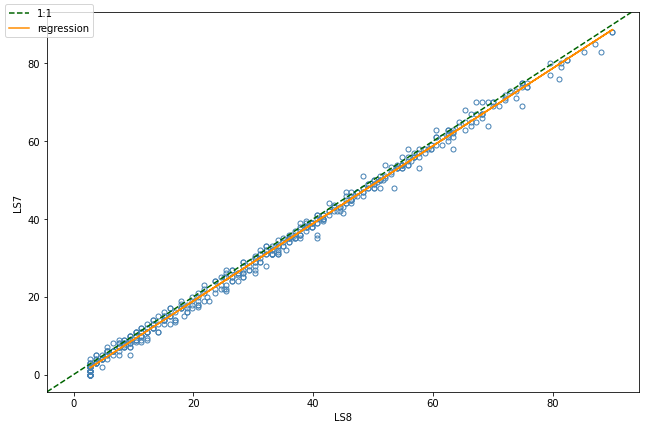

In [89]:
fig, axs = plt.subplots(1, 1,  sharey=True, sharex=True, figsize=(9, 6))
axs.plot(max_median_ls8["pv"], max_median_ls7["pv"], 'o',  color='SteelBlue',  mfc='none', markersize=5)
axs.set_xlabel("LS8")
axs.set_ylabel("LS7")
axs.axline([0, 0], [1, 1], color='darkgreen', ls='--', label="1:1")
axs.plot(max_median_ls8["pv"], fc_lin["pv"].slope*np.array(max_median_ls8["pv"])+fc_lin["pv"].intercept, color='darkorange', label='regression')
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig('fc_diff_plot/' + 'fc_regression_on_fc.png', bbox_inches='tight')

In [82]:
chunks = {"y": -1, "x": -1}
first = False
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
for grid in test_grids:
    print("grid", grid)
    query_poly = poly_from_region_code(grid, "../../../au-grid.geojson")
    c3_query = {'geopolygon': query_poly}
    c3_query['time'] = ('2014-01-01', '2021-01-01')
    geobox = GeoBox.from_geopolygon(query_poly, (-30, 30), crs='epsg:3577')

    c3_ls8_datasets = dc.find_datasets(product=['ga_ls_fc_3', 'ga_ls_wo_3'], **c3_query,
                 platform="landsat-8", group_by="solar_day")
    c3_ls8_datasets = ds_align(c3_ls8_datasets)
    c3_ls8 = load_with_native_transform(
        c3_ls8_datasets,
        bands=["water", "pv", "bs", "npv"],
        geobox=geobox,
        native_transform=_native_tr,
        fuser=_fuser,
        groupby="solar_day",
        resampling="bilinear",
        chunks=chunks,
    )
    c3_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp",
                                      c3_ls8.pv.shape[1:], (c3_ls8.x.data.min(), c3_ls8.y.data.max()), (30, -30))
    c3_ls8 = c3_ls8.where((c3_ls8 < 255) & c3_land_raster)
    for key, value in fc_lin.items():
        c3_ls8[key] = c3_ls8[key] * value.slope + value.intercept
    ls8_pc_10 = c3_ls8.quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('spec', how='all')
    ls8_pc_10 = ls8_pc_10.reset_index(['time', 'idx', 'uuid', 'grid'], drop=True).rename({'spec': 'time'}).to_dataframe()
    ls8_pc_10.to_csv("fc_diff_data/" + grid.lower() + '_fc_ls8_c3_lt.csv')

grid x12y19
grid X12y20
grid x15y29
grid x14y29
grid x17y20
grid x18y20
grid x17y19
grid x18y19
grid x19y25
grid x20y25
grid x28y42
grid x28y43
grid x28y31
grid x33y25
grid x35y29
grid x35y22
grid x36y22
grid x35y21
grid x39y38
grid x40y38
grid x38y20
grid x38y21
grid x37y21
grid x37y20
grid x38y15
grid x39y15
grid x39y13
grid x40y13
grid x42y37
grid x42y38
grid x40y07
grid x41y07
grid x43y14
grid x43y15
grid x44y16
grid x44y17
grid x44y15
grid x47y25
grid x45y16
grid x45y17
grid x46y17
grid x49y24
grid x49y23
grid x17y37
grid x18y37
grid x24y40
grid x27y42
grid x27y43
grid x31y40
grid x37y36
grid x38y37
grid x43y35


In [ ]:
test_grids[np.argsort(max_median)]

In [ ]:
fig, axs = plt.subplots(3, 3,  sharey=True, sharex=True, figsize=(15, 15))
i = 0
j = 0
year = 2014
pcs = [0.2, 0.5, 0.8]
for y in range(2014, 2021):
    data_to_plot = []
    for p in pcs:
        data_to_plot += [ls7_pc.pv.loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')],
                         ls8_pc.pv.loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')]]
    box_plot = axs[i, j].boxplot(data_to_plot,
                  positions=[1, 1.6, 2.5, 3.1, 4, 4.6],
                  labels=['LS7-20','LS8-20','LS7-50','LS8-50','LS7-80','LS8-80'])
    axs[i, j].set_title(str(y))
    if j >= 2:
        i += 1
        j = 0
    else:
        j += 1
plt.savefig(test_grids[0] + '_pv_c3_yearly_diff.png', bbox_inches='tight')

In [ ]:
for grid in test_grids:
    query_poly = poly_from_region_code(grid, "../../../au-grid.geojson")
    c3_query = {'geopolygon': query_poly}
    c3_query['time'] = ('2014-01-01', '2020-01-01')
    c2_ls7 = dc.load(product=['ls7_fc_albers'], **c3_query, group_by="solar_day", measurements=['BS', 'PV', 'NPV'], 
                     dask_chunks={'time':1})
    c2_wofs = dc.load(product=['wofs_albers'], **c3_query, group_by="solar_day", platform='LANDSAT_7', measurements=['water'],
                      dask_chunks={'time':1})
    c2_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp", c2_ls7.PV.shape[1:],
                                      (c2_ls7.x.data.min(), c2_ls7.y.data.max()), (25, -25))
    dates = np.intersect1d(c2_ls7.time.data, c2_wofs.time.data)
    water = c2_wofs.water & 0b1110_1011
    dry = water == 0
    c2_ls7 = c2_ls7.loc[dict(time=dates)]
    dry = dry.loc[dict(time=dates)]
    c2_ls7 = c2_ls7.where((c2_ls7 > -1) & dry & c2_land_raster)

    c2_ls8 = dc.load(product=['ls8_fc_albers'], **c3_query, group_by="solar_day", measurements=['BS', 'PV', 'NPV'], 
                     dask_chunks={'time':1})
    c2_wofs = dc.load(product=['wofs_albers'], **c3_query, group_by="solar_day", platform='LANDSAT_8', measurements=['water'],
                      dask_chunks={'time':1})
    dates = np.intersect1d(c2_ls8.time.data, c2_wofs.time.data)
    water = c2_wofs.water & 0b1110_1011
    dry = water == 0
    c2_ls8 = c2_ls8.loc[dict(time=dates)]
    dry = dry.loc[dict(time=dates)]
    c2_ls8 = c2_ls8.where((c2_ls8 > -1) & dry & c2_land_raster)

    ls7_pc_10 = c2_ls7.quantile([0.2, 0.5, 0.8], dim=['x', 'y'], skipna=True).compute().dropna('time', how='all')
    ls8_pc_10 = c2_ls8.quantile([0.2, 0.5, 0.8], dim=['x', 'y'], skipna=True).compute().dropna('time', how='all')
    ls7_pc_10 = ls7_pc_10.to_dataframe()
    ls8_pc_10 = ls8_pc_10.to_dataframe()
    ls7_pc_10.to_csv(grid.lower() + '_fc_ls7_c2.csv')
    ls8_pc_10.to_csv(grid.lower() + '_fc_ls8_c2.csv')

In [ ]:
fig, axs = plt.subplots(3, 3,  sharey=True, sharex=True, figsize=(15, 15))
i = 0
j = 0
year = 2014
pcs = [0.2, 0.5, 0.8]
for y in range(2014, 2021):
    data_to_plot = []
    for p in pcs:
        data_to_plot += [ls7_pc_c2.PV.loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')],
                         ls8_pc_c2.PV.loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')]]
    box_plot = axs[i, j].boxplot(data_to_plot,
                  positions=[1, 1.6, 2.5, 3.1, 4, 4.6],
                  labels=['LS7-20','LS8-20','LS7-50','LS8-50','LS7-80','LS8-80'])
    axs[i, j].set_title(str(y))
    if j >= 2:
        i += 1
        j = 0
    else:
        j += 1
plt.savefig(test_grids[0] +'_pv_c2_yearly_diff.png', bbox_inches='tight')

In [20]:
landsat_shape = "../../../landsat_au/landsat_au.shp"
grid_shape = "../../../au-grid.geojson"
au_shape = "../../../aus_map/cstauscd_r.shp"
land_scenes = landsat_land_scenes(landsat_shape, au_shape)

In [16]:
test_scenes = np.array(land_scenes)[list(np.random.uniform(0, len(land_scenes), 40).astype('int'))]

In [17]:
test_scenes

array([102071,  89081,  92089, 107075,  95077,  93078, 105067, 110074,
        97072, 115080, 113077,  90088,  94087,  95072, 111078,  93075,
       110084, 112076, 109081,  92075, 103081,  99073, 106070,  89082,
       104071, 102075,  99083, 101071, 103070, 113078,  92078, 111081,
       111074, 108070,  91076, 101077,  97070, 104070,  98077,  97073])

In [20]:
test_scenes = []
for grid in test_grids:
    query_poly_dict = locate_landsat_scene(landsat_shape, grid_shape, grid.lower())
    for key in query_poly_dict.keys():
        test_scenes += [key]

In [21]:
test_scenes

[112082,
 112083,
 113082,
 113083,
 112081,
 112082,
 113081,
 113082,
 111076,
 111077,
 111076,
 111077,
 112076,
 112077,
 108082,
 109082,
 110082,
 108082,
 109082,
 108082,
 108083,
 109082,
 109083,
 108082,
 108083,
 109082,
 109083,
 108079,
 108080,
 109079,
 107079,
 107080,
 108079,
 104069,
 104070,
 105069,
 104068,
 104069,
 105068,
 105069,
 104075,
 104076,
 103075,
 103076,
 100079,
 99079,
 99080,
 98077,
 99076,
 99077,
 97081,
 98081,
 96081,
 97081,
 97081,
 97082,
 98081,
 98082,
 97071,
 97072,
 98071,
 98072,
 97071,
 97072,
 98071,
 95082,
 96082,
 95081,
 95082,
 96081,
 96082,
 95081,
 95082,
 96081,
 96082,
 95082,
 96082,
 95085,
 93085,
 94085,
 93085,
 94085,
 92086,
 92087,
 93086,
 93087,
 94086,
 92086,
 92087,
 93086,
 95072,
 96071,
 96072,
 96071,
 97071,
 90089,
 90090,
 91089,
 91090,
 89089,
 89090,
 90089,
 90090,
 91089,
 91090,
 90085,
 90086,
 91085,
 91086,
 90084,
 90085,
 91084,
 91085,
 90084,
 91084,
 90083,
 90084,
 91083,
 91084,
 89

In [35]:
added_scenes = (set(test_scenes) - set(done_scenes))

In [25]:
set(done_scenes)

{100079,
 102070,
 102071,
 103070,
 103071,
 103075,
 103076,
 104068,
 104069,
 104070,
 104075,
 104076,
 105068,
 105069,
 105070,
 106068,
 106069,
 106070,
 106071,
 107070,
 107071,
 107079,
 107080,
 108079,
 108080,
 108082,
 108083,
 109072,
 109079,
 109082,
 109083,
 110072,
 110082,
 111071,
 111072,
 111076,
 111077,
 112076,
 112077,
 112081,
 112082,
 112083,
 113081,
 113082,
 113083}

In [28]:
latlon_list = []
for pr in set(done_scenes):
    #if  pr != 102082 and not first:
    #    continue
    #if pr == 102082:
    #    first = True
    query_poly_dict = landsat_scene_poly(landsat_shape, int(pr))
    for v in query_poly_dict.values():
        latlon_list += [(pr, ) + v.geom.bounds]

In [30]:
np.savetxt("../../../latlon_scenes_samples.txt", np.array(latlon_list), fmt="%.5f")

In [249]:
chunks = {"y": -1, "x": -1}
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
first = False
landsat_shape = "../../../landsat_au/landsat_au.shp"
grid_shape = "../../../au-grid.geojson"
au_shape = "../../../aus_map/cstauscd_r.shp"
land_scenes = landsat_land_scenes(landsat_shape, au_shape)
#for grid in test_grids:
    #query_poly_dict = locate_landsat_scene(landsat_shape, grid_shape, grid.lower())
for pr in land_scenes:
    #if  pr != 102082 and not first:
    #    continue
    #if pr == 102082:
    #    first = True
    query_poly_dict = landsat_scene_poly(landsat_shape, pr)
    for region_code, query_poly in query_poly_dict.items():
        print("process scene", region_code)
        if os.path.exists('nbart_diff_data/' + str(region_code) + '_nbart_ls7_c3_native.csv'):
            continue
        ls7_pc = pd.DataFrame()
        ls8_pc = pd.DataFrame()
        c3_query = {'geopolygon': query_poly}
        c3_query['region_code'] = str(region_code)
        for year in range(2014, 2021):
            print("year", year)
            c3_query['time'] = (str(year)+'-01-01', str(year+1)+'-01-01')

            c3_ls7_datasets = dc.find_datasets(product='ga_ls7e_ard_3', **c3_query)
            c3_ls7 = native_load_mask_nbart(c3_ls7_datasets)
            c3_ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **c3_query)
            c3_ls8 = native_load_mask_nbart(c3_ls8_datasets)
            
            for crs in c3_ls7.keys(): 
                x_coords = np.intersect1d(c3_ls7[crs].x, c3_ls8[crs].x)
                y_coords = np.intersect1d(c3_ls7[crs].y, c3_ls8[crs].y)
                print("crs", crs)
                print("data size", (len(y_coords), len(x_coords)))
                if len(x_coords) == 0 or len(y_coords) == 0:
                    continue
                with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                    c3_ls7[crs] = c3_ls7[crs].loc[dict(y=y_coords, x=x_coords)]
                    c3_ls8[crs] = c3_ls8[crs].loc[dict(y=y_coords, x=x_coords)]
                c3_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp",
                                                  c3_ls7[crs].blue.shape[1:], (c3_ls7[crs].x.data.min()+15, c3_ls7[crs].y.data.max()-15), (30, -30),
                                                 int(c3_ls7[crs].spatial_ref.data))
                c3_ls7[crs] = c3_ls7[crs].where((c3_ls7[crs] > -999) & c3_land_raster)
                c3_ls8[crs] = c3_ls8[crs].where((c3_ls8[crs] > -999) & c3_land_raster)
                ls7_pc_10 = c3_ls7[crs].quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('time', how='all').to_dataframe()
                ls8_pc_10 = c3_ls8[crs].quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('time', how='all').to_dataframe()
                ls7_pc = pd.concat([ls7_pc, ls7_pc_10])
                ls8_pc = pd.concat([ls8_pc, ls8_pc_10])
        if len(ls7_pc) > 0:
            ls7_pc.to_csv('nbart_diff_data/' + str(region_code) + '_nbart_ls7_c3_native.csv')
        if len(ls8_pc) > 0:
            ls8_pc.to_csv('nbart_diff_data/' + str(region_code) + '_nbart_ls8_c3_native.csv')

process scene 98066
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 99066
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 98067
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 99067
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95072
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95073
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95074
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95075
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95076
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95077
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process scene 95078
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
process sc

In [ ]:
fig, axs = plt.subplots(3, 3,  sharey=True, sharex=True, figsize=(15, 15))
i = 0
j = 0
year = 2014
for a, b in zip(ls7_pc, ls8_pc):
    data_to_plot = []
    for _a, _b in zip(a.swir1, b.swir1):
        data_to_plot += [_a, _b]
    box_plot = axs[i, j].boxplot(data_to_plot, showfliers=False,
                  positions=[1, 1.6, 2.5, 3.1, 4, 4.6],
                  labels=['LS7-20','LS8-20','LS7-50','LS8-50','LS7-80','LS8-80'])
    axs[i, j].set_title(str(year))
    year += 1
    if j >= 2:
        i += 1
        j = 0
    else:
        j += 1

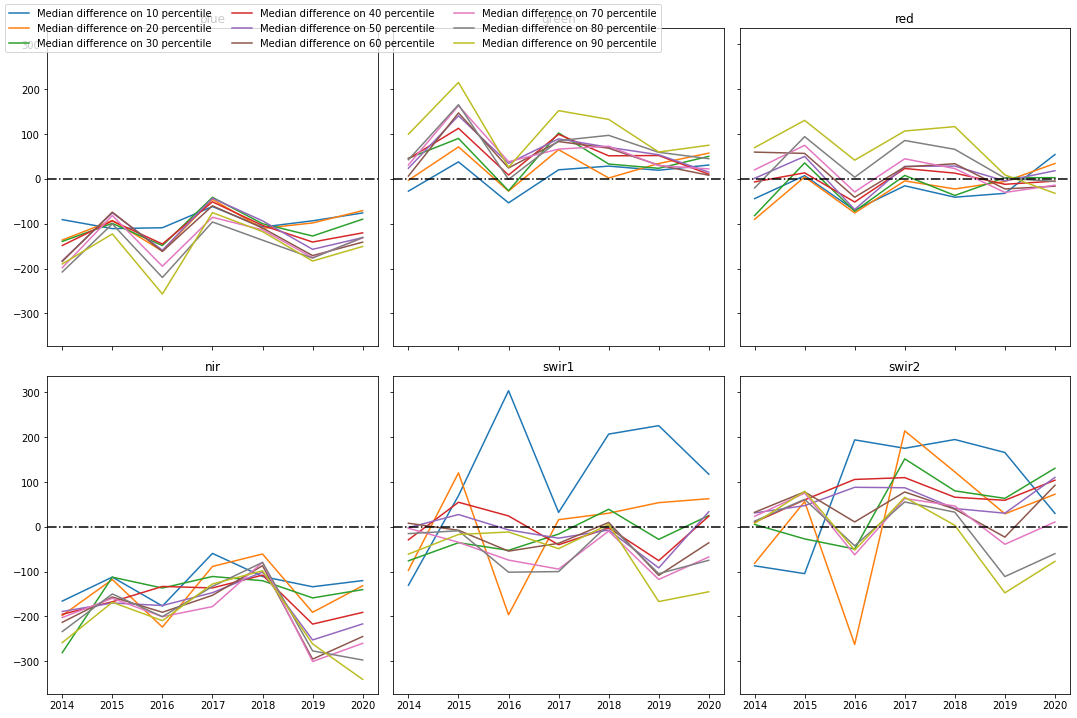

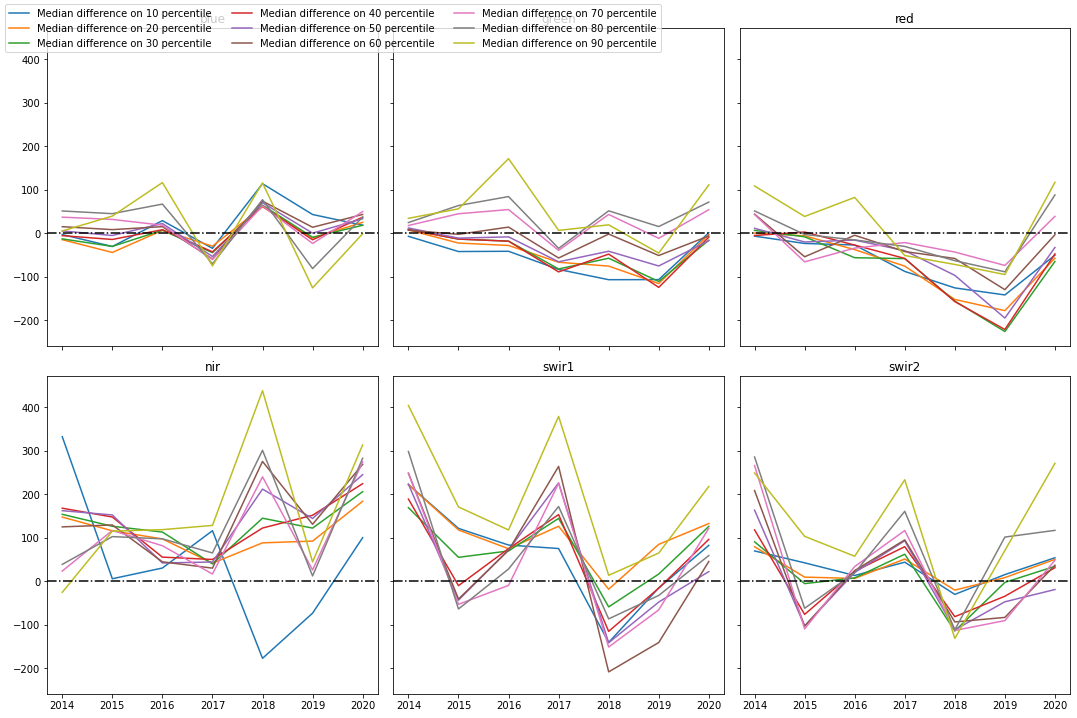

In [54]:
sf_bands = ["blue", "green", "red", "nir", "swir1", "swir2"]
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
for grid in test_grids:
    grid = grid.lower()
    if grid != 'x33y25' and grid != 'x43y35':
        continue
    ls8_pc = pd.read_csv('nbart_diff_data/'+grid+'_nbart_ls8_c3_lt.csv')
    ls8_pc['time'] = ls8_pc['time'].astype(np.datetime64)
    ls8_pc = ls8_pc.set_index(['quantile', 'time'])
    ls7_pc = pd.read_csv('nbart_diff_data/'+grid+'_nbart_ls7_c3.csv')
    ls7_pc['time'] = ls7_pc['time'].astype(np.datetime64)
    ls7_pc = ls7_pc.set_index(['quantile', 'time'])
    fig, axs = plt.subplots(2, 3,  sharey=True, sharex=True, figsize=(15, 10))
    data_to_plot = []
    i = 0
    j = 0
    for band in sf_bands:
        for p in pcs:
            data_to_plot = []
            for y in range(2014, 2021):
                data_to_plot += [ls8_pc[band].loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')].median() - 
                                 ls7_pc[band].loc[p].loc[slice(str(y)+'-01-01', str(y+1)+'-01-01')].median()]
            axs[j, i].plot(np.arange(2014, 2021), data_to_plot, label="Median difference on %s percentile" %  int(p*100))
        axs[j, i].axhline(y=0, color='black', linestyle='dashdot')
        axs[j, i].set_title(band)
        if i >= 2:
            j += 1
            i = 0
        else:
            i += 1
    plt.tight_layout()
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', ncol=3)
    plt.savefig('nbart_diff_plot/' + grid +'_nbar_c3_yearly_median_diff_lt.png', bbox_inches='tight')
    #plt.close()

In [ ]:
for band in sf_bands:
    for q in range(3):
        data_to_plot = []
        for a, b in zip(ls7_pc, ls8_pc):
            data_to_plot += [np.median(b[band].data[q]) - np.median(a[band].data[q])]
        axs[j, i].plot(np.arange(2014, 2021), data_to_plot, label="Median difference on %s percentile" %  pcs[q])

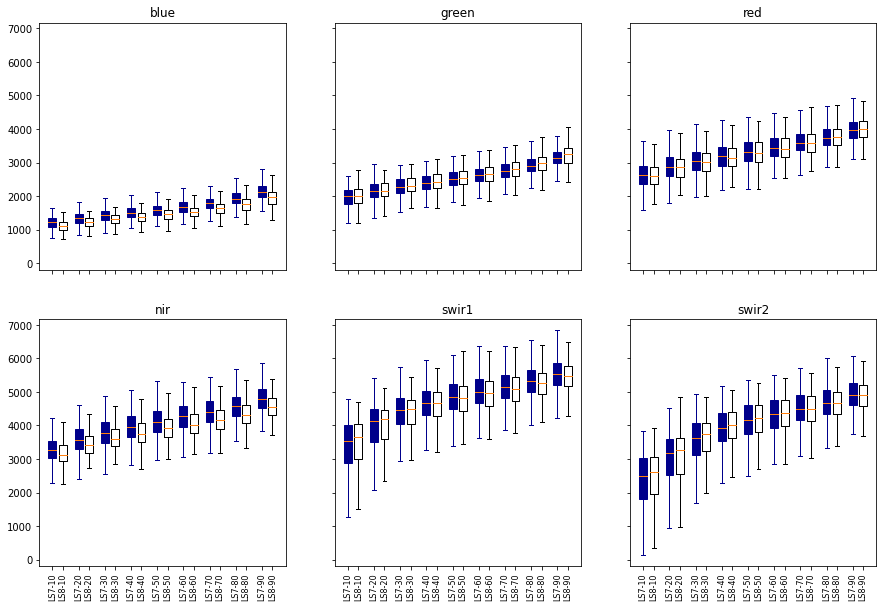

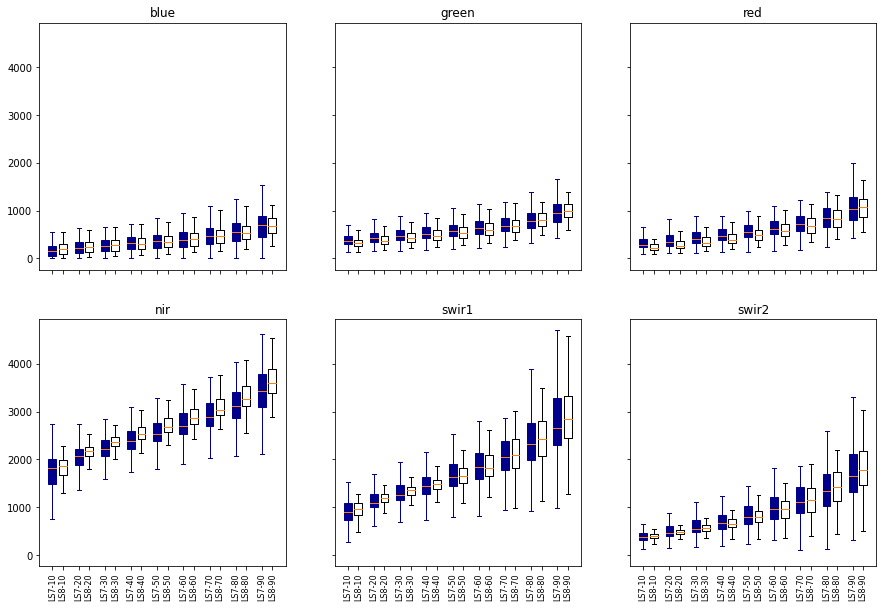

In [55]:
pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
for grid in test_grids:
    grid = grid.lower()
    if grid != 'x33y25' and grid != 'x43y35':
        continue
    ls8_pc = pd.read_csv('nbart_diff_data/'+grid+'_nbart_ls8_c3_lt.csv')
    ls8_pc['time'] = ls8_pc['time'].astype(np.datetime64)
    ls8_pc = ls8_pc.set_index(['quantile', 'time'])
    ls7_pc = pd.read_csv('nbart_diff_data/'+grid+'_nbart_ls7_c3.csv')
    ls7_pc['time'] = ls7_pc['time'].astype(np.datetime64)
    ls7_pc = ls7_pc.set_index(['quantile', 'time'])
    fig, axs = plt.subplots(2, 3,  sharey=True, sharex=True, figsize=(15, 10))
    i = 0
    j = 0
    for band in sf_bands:
        pcs = [np.around(a, 1) for a in np.arange(0.1, 1, 0.1)]
        positions = np.arange(1, (len(pcs) + 1), 1.0)
        labels_ls7 = ['LS7-'+str(int(p*100)) for p in pcs]
        data_to_plot = []
        for p in pcs:
            data_to_plot += [ls7_pc[band].loc[p]]
        box_plot_ls7 = axs[j, i].boxplot(data_to_plot, vert=1, widths=0.3, patch_artist=True, showfliers=False,
                      positions=positions,
                      labels=labels_ls7)

        axs[j, i].set_xticks(list(positions) + list(positions+0.4))
        positions += 0.4
        labels_ls8 = ['LS8-'+str(int(p*100)) for p in pcs]
        data_to_plot = []
        for p in pcs:
            data_to_plot += [ls8_pc[band].loc[p]]
        box_plot_ls8 = axs[j, i].boxplot(data_to_plot, vert=1, widths=0.3, showfliers=False,
                      positions=positions,
                      labels=labels_ls8)
        for item in ['boxes', 'whiskers', 'caps']:
            plt.setp(box_plot_ls7[item], color='darkblue')
        axs[j, i].set_xticks(list(positions) + list(positions-0.4))
        axs[j, i].set_xticklabels(labels_ls8+labels_ls7,
                                  rotation=90, fontsize=8)
        axs[j, i].set_title(band)
        if i >= 2:
            j += 1
            i = 0
        else:
            i += 1
    plt.savefig('nbart_diff_plot/' + grid +'_nbar_alltime_diff_lt.png', bbox_inches='tight')
    #plt.close()

In [5]:
nbart_scenes = pd.read_csv("nbart_diff_data/nbart_scenes.csv", header=None)

In [6]:
done_scenes = []
for scene in nbart_scenes[0]:
    done_scenes += [int(re.findall(r"\d+(?=_)", scene)[0])]

In [7]:
len(set(test_scenes))

NameError: name 'test_scenes' is not defined

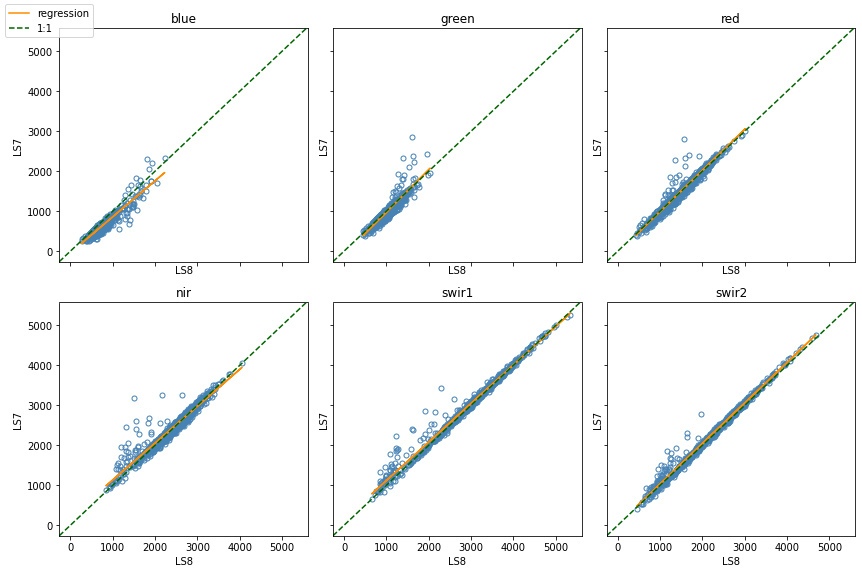

In [40]:
sf_bands = ["blue", "green", "red", "nir", "swir1", "swir2"]
pcs = [np.around(a, 1) for a in np.arange(0.2, 1, 0.2)]
fig, axs = plt.subplots(2, 3,  sharey=True, sharex=True, figsize=(12, 8))
max_median_ls8 = {}
max_median_ls7 = {}
nbart_lin ={}
nbart_scenes = pd.read_csv("nbart_diff_data/nbart_scenes_all.csv", header=None)
test_scenes = []
for scene in nbart_scenes[0]:
    test_scenes += [re.findall(r"\d+(?=_)", scene)[0]]
    
for band in sf_bands:
    max_median_ls8[band] = []
    max_median_ls7[band] = []
for scene in set(test_scenes):
# for scene in test_grids:
    scene = scene.lower()
    ls8_pc = pd.read_csv('nbart_diff_data/'+scene+'_nbart_ls8_c3_native.csv')
    ls8_pc['time'] = ls8_pc['time'].astype(np.datetime64)
    ls8_pc = ls8_pc.set_index(['quantile', 'time'])
    ls7_pc = pd.read_csv('nbart_diff_data/'+scene+'_nbart_ls7_c3_native.csv')
    ls7_pc['time'] = ls7_pc['time'].astype(np.datetime64)
    ls7_pc = ls7_pc.set_index(['quantile', 'time'])
    for p in pcs:
        _, ls8_index, ls7_index = np.intersect1d(ls8_pc.loc[p].index.get_level_values('time').date + timedelta(days=8), 
                                               ls7_pc.loc[p].index.get_level_values('time').date, return_indices=True)
               
        for band in sf_bands:    
            # max_median_ls8[band] += list(ls8_pc.loc[p].iloc[ls8_index][band].rolling(50).mean().dropna())
            # max_median_ls7[band] += list(ls7_pc.loc[p].iloc[ls7_index][band].rolling(50).mean().dropna())
            max_median_ls8[band] += list([ls8_pc.loc[p].iloc[ls8_index][band].mean()])
            max_median_ls7[band] += list([ls7_pc.loc[p].iloc[ls7_index][band].mean()])
i = 0
j = 0
for band in sf_bands:
    nbart_lin[band] = linregress(max_median_ls8[band], max_median_ls7[band])
    axs[j, i].plot(max_median_ls8[band], max_median_ls7[band], 'o', color='SteelBlue',  mfc='none', markersize=5)
    axs[j, i].plot(max_median_ls8[band], nbart_lin[band].slope*np.array(max_median_ls8[band])+nbart_lin[band].intercept, color='darkorange',
                   label="regression")
    axs[j, i].axline([0, 0], [1, 1], color='darkgreen', ls='--', label="1:1")
    axs[j, i].set_title(band)
    axs[j, i].set_xlabel("LS8")
    axs[j, i].set_ylabel("LS7")
    if i >= 2:
        j += 1
        i = 0
    else:
        i += 1
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig('nbart_diff_plot/' + 'nbart_regression_lt.png', bbox_inches='tight')

In [41]:
nbart_lin

{'blue': LinregressResult(slope=0.9009983764016564, intercept=-42.02463364026494, rvalue=0.9400524961697211, pvalue=0.0, stderr=0.01118498121376765, intercept_stderr=8.438126764323492),
 'green': LinregressResult(slope=1.064822307724856, intercept=-89.84544342270112, rvalue=0.916477260049018, pvalue=0.0, stderr=0.015906722829680597, intercept_stderr=16.32256818049697),
 'red': LinregressResult(slope=1.0293363027303208, intercept=-39.18842784026447, rvalue=0.9733335733317989, pvalue=0.0, stderr=0.008301361276852322, intercept_stderr=12.736541526281405),
 'nir': LinregressResult(slope=0.9216734329176915, intercept=211.83370600899661, rvalue=0.9592767564005938, pvalue=0.0, stderr=0.009286953833335783, intercept_stderr=22.25215566168204),
 'swir1': LinregressResult(slope=0.9636030771507015, intercept=155.0303041655352, rvalue=0.9909981764656206, pvalue=0.0, stderr=0.004454480541802818, intercept_stderr=13.17701938714031),
 'swir2': LinregressResult(slope=1.0137475476349898, intercept=18.80

In [ ]:
{'blue': LinregressResult(slope=0.8995040368916818, intercept=-46.43616499174664, rvalue=0.9477912904179733, pvalue=3.892135039636259e-202, stderr=0.0150758070180556, intercept_stderr=10.39921022730542),
 'green': LinregressResult(slope=0.9746881512508464, intercept=-31.877623533137125, rvalue=0.9706258032788352, pvalue=1.8611805751234255e-251, stderr=0.012035008826980062, intercept_stderr=11.542018583669988),
 'red': LinregressResult(slope=1.0187161740702173, intercept=-49.650785489851614, rvalue=0.9913548841930073, pvalue=0.0, stderr=0.006716318256580001, intercept_stderr=8.772187528630036),
 'nir': LinregressResult(slope=0.9669386992047916, intercept=49.88078399980577, rvalue=0.9908601696623598, pvalue=0.0, stderr=0.006557276454381965, intercept_stderr=15.45808265322962),
 'swir1': LinregressResult(slope=1.0066624621755362, intercept=-7.342679023162418, rvalue=0.9984844790063951, pvalue=0.0, stderr=0.0027638941149786974, intercept_stderr=7.314700556621267),
 'swir2': LinregressResult(slope=1.0364065364956483, intercept=-60.99951298315568, rvalue=0.9985055574077312, pvalue=0.0, stderr=0.00282565693282791, intercept_stderr=5.53982524660025)}

In [34]:
chunks = {"y": -1, "x": -1}

for grid in test_grids:
    grid = grid.lower()
    # if grid != 'x33y25' and grid != 'x43y35':
    #    continue
    query_poly = poly_from_region_code(grid, "../../../au-grid.geojson")
    c3_query = {'geopolygon': query_poly}
    c3_query['time'] = ('2014-01-01', '2021-01-01')
    geobox = GeoBox.from_geopolygon(query_poly, (-30, 30), crs='epsg:3577')
    
    c3_ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **c3_query)
    c3_ls8 = load_with_native_transform(
        c3_ls8_datasets,
        bands=["blue", "green", "red", "nir", "swir1", "swir2", "fmask", "nbart_contiguity"],
        geobox=geobox,
        native_transform=_native_tr_nbart,
        fuser=_fuser_nbart,
        groupby="solar_day",
        resampling="nearest",
        chunks=chunks,
    )
    
    c3_land_raster = generate_seamask("../../../aus_map/cstauscd_r_3577.shp",
                                          c3_ls8.blue.shape[1:], (c3_ls8.x.data.min(), c3_ls8.y.data.max()), (30, -30))
        
    c3_ls8 = c3_ls8.where((c3_ls8 > -999) & c3_land_raster)
    for key, value in nbart_lin.items():
        c3_ls8[key] = c3_ls8[key] * value.slope + value.intercept
    c3_ls8 = c3_ls8.clip(min=0)
    ls8_pc_10 = c3_ls8.quantile(pcs, dim=['x', 'y'], skipna=True).compute().dropna('spec', how='all')
    ls8_pc_10 = ls8_pc_10.reset_index(['time', 'idx', 'uuid', 'grid'], drop=True).rename({'spec': 'time'}).to_dataframe()
    ls8_pc_10.to_csv('nbart_diff_data/' + grid.lower() + '_nbart_ls8_c3_lt.csv')

CPLReleaseMutex: Error = 1 (Operation not permitted)
/home/jovyan/need_installed/odc-tools/libs/algo/odc/algo/_masking.py:757: RuntimeWarning: invalid value encountered in true_divide
  out = np.round(out / count).astype(aa[0].dtype)
/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/nanny.py", line 789, in _run
    loop.run_sync(run)
  File "/env/lib/python3.8/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
CPLReleaseMutex: Error = 1 (Operation not permitted)


In [ ]:
fig, axs = plt.subplots(figsize=(16, 9))

data_to_plot = []
for a, b in zip(ls7_box, ls8_box):
    data_to_plot += [a, b]
box_plot = plt.boxplot(data_to_plot, showfliers=False,
                  positions=[1, 1.6, 2.5, 3.1, 4, 4.6],
                  labels=['LS7-20','LS8-20','LS7-50','LS8-50','LS7-80','LS8-80'])

In [ ]:
# title too long for C2, drop spatial_ref: 3577
re_c2 = re_c2.drop_vars('spatial_ref')

In [ ]:
re_c2.PV_PC_10.loc[dict(time='2014-01-01')].where(c2_land_raster > 0).compute().plot(aspect=1.5, size=10)

In [ ]:
# plot the valid data for a band
(re_c2.PV_PC_10.loc[dict(time='2014-01-01')]-re_c2.PV_PC_10.loc[dict(time='2010-01-01')]).where(c2_land_raster > 0).compute().plot(aspect=1.5, size=10)
#plt.savefig('x45y17_2018_c2.png', bbox_inches='tight')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2021

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 8`, :index:`landsat 7`, :index: `landsat 5`, :index: `fc percentile`